# Necessary libraries

In [1]:
#!kaggle competitions download -c g2net-gravitational-wave-detection

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
from functools import reduce
from sklearn.model_selection import train_test_split
from scipy import signal

In [3]:
path = pathlib.Path('/home/carlos/Documentos/Kaggle/g2net')

In [4]:
sample_submission = pd.read_csv(path / 'sample_submission.csv')

# Reading the dataset 

In [5]:
training_labels = pd.read_csv(path / 'training_labels.csv', index_col='id', dtype={'id': str, 'target': np.int16})

In [6]:
# Each id corresponds to a numpy array filename under /train
training_labels.head()

,target
id,
00000e74ad,1
00001f4945,0
0000661522,0
00007a006a,0
0000a38978,1


In [7]:
# List of all filenames under /train and /test
training_set = list((path / 'train').rglob('*.*'))
valid_set = list((path / 'test').rglob('*.*')) # Kaggle "test" set will actually be the validation set on this notebook's scope. A test set will be splitted from the training set.
len(training_set), len(valid_set)

(560000, 226000)

In [8]:
# Numpy arrays are stored under some unknown hierarchy under /train, but its filename always corresponds to an id found in 'training_labels'
training_set[:3]

[PosixPath('/home/carlos/Documentos/Kaggle/g2net/train/5/5/5/55517ec769.npy'),
 PosixPath('/home/carlos/Documentos/Kaggle/g2net/train/5/5/5/555114c239.npy'),
 PosixPath('/home/carlos/Documentos/Kaggle/g2net/train/5/5/5/555e0035d9.npy')]

In [9]:
# Creation of a DataFrame with full path and id of numpy arrays, along with its label
training_df_complete = pd.DataFrame(training_set, columns=['path'], dtype=object)
training_df_complete['id'] = training_df_complete.apply(lambda x: x['path'].name.split('.')[0], axis=1).astype('string')
training_df_complete = pd.merge(training_df_complete, training_labels, how='left', on='id')
training_df_complete = training_df_complete.set_index('id')

In [10]:
training_df_complete.head(7)

,path,target
id,,
55517ec769,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,0
555114c239,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,0
555e0035d9,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,0
555f38703c,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,0
555ffd84ca,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,0
555508090c,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,1
55542ddf23,/home/carlos/Documentos/Kaggle/g2net/train/5/5...,0


In [11]:
# Creation of the test set
id_train, id_test, _, _ = train_test_split(training_df_complete.index, training_df_complete['target'], test_size=0.2, random_state=42)

In [12]:
training_df = training_df_complete.loc[id_train]
test_df = training_df_complete.loc[id_test]

In [13]:
training_df.shape, test_df.shape

((448000, 2), (112000, 2))

In [14]:
# Creation of the validation DataFrame, only with paths and ids
valid_df = pd.DataFrame(valid_set, columns=['path'], dtype=object)
valid_df['id'] = valid_df.apply(lambda x: x['path'].name.split('.')[0], axis=1).astype('string')

In [15]:
valid_df.head()

,path,id
0,/home/carlos/Documentos/Kaggle/g2net/test/5/5/...,555fae21f9
1,/home/carlos/Documentos/Kaggle/g2net/test/5/5/...,5550b3009c
2,/home/carlos/Documentos/Kaggle/g2net/test/5/5/...,55554b8e3c
3,/home/carlos/Documentos/Kaggle/g2net/test/5/5/...,55535b070b
4,/home/carlos/Documentos/Kaggle/g2net/test/5/5/...,555d90926b


# Quick glance at the data (EDA)

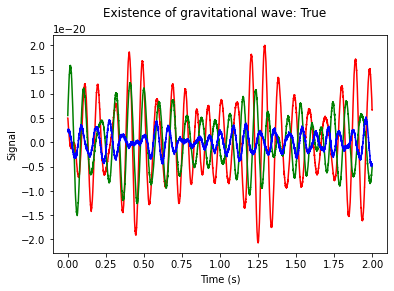

In [16]:
idx = 7
arr = np.load(training_df['path'].iloc[idx])
t = np.arange(2 * 2048) / 2048 # Signal lasts for 2 seconds and is sampled at 2048 Hz

fig, ax = plt.subplots(1, 1)
ax.plot(t, arr[0], color='r')
ax.plot(t, arr[1], color='g')
ax.plot(t, arr[2], color='b')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal')
_ = fig.suptitle(f'Existence of gravitational wave: {bool(training_df["target"].iloc[idx])}')

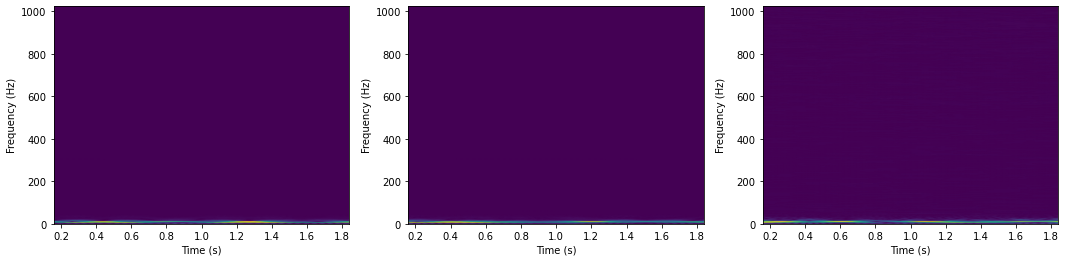

In [17]:
magnifier = 10. ** 24
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
nperseg=650
noverlap=640

for i in range(3):
    curr_arr = np.copy(arr[i]) * magnifier
    f, t, Sxx = signal.spectrogram(curr_arr, fs=2048., window=('tukey', 0.25), nperseg=nperseg, noverlap=noverlap, scaling='density', mode='magnitude')
    axes[i].pcolormesh(t, f, Sxx, shading='gouraud')
    axes[i].set_ylabel('Frequency (Hz)')
    _ = axes[i].set_xlabel('Time (s)')

In [18]:
spec_shape = Sxx.shape
spec_shape

(326, 345)

In [19]:
f, t, Sxx = signal.spectrogram(arr, fs=2048., window=('tukey', 0.25), nperseg=nperseg, noverlap=noverlap, scaling='density', axis=-1, mode='magnitude')

In [20]:
curr_arr.dtype

dtype('float64')

In [21]:
Sxx.max()

3.5336264630751954e-21

In [22]:
# Checking numpy array sizes of all elements (slow)
def get_array_sizes(df, path_col='path', load_func=lambda x: np.load(x), chunk_size=10000):
    steps = int(np.ceil(df.shape[0] / chunk_size))
    excess = steps * chunk_size - df.shape[0]
    sizes = []
    for step in range(steps):
        curr_chunk = chunk_size if step < steps or excess == 0 else excess
        curr_start = step * chunk_size
        curr_df = df.iloc[curr_start : curr_start + curr_chunk, :]
        sizes.extend([load_func(pth).shape for pth in curr_df[path_col]])
    return sizes

In [23]:
# %time sizes_train = get_array_sizes(training_df_complete)

In [24]:
# %time sizes_valid = get_array_sizes(valid_df)

In [25]:
# All sizes in the training set are unique and equal to (3, 4096) -> 3 signals of 2 sec at 2048 Hz
# sizes_train_unique = list(dict.fromkeys(sizes_train))
# sizes_train_unique

In [26]:
# Same for the test set
# sizes_valid_unique = list(dict.fromkeys(sizes_valid))
# sizes_valid_unique

# Creating a Dataset

## Generators

In [27]:
batch_size = 32

In [28]:
# def g2net_data_generator(df, batch_size=64, magnifier=10.**20):
#     def gen():
#         steps = int(np.floor(df.shape[0] / batch_size))
#         for step in range(steps):
#             curr_df = df.iloc[step * batch_size: (step + 1) * batch_size]
#             arrs = [np.load(row[1]).astype(np.float64) for row in curr_df.itertuples()]
#             spec_results = [
#                 signal.spectrogram(magnifier * arr, fs=2048., nperseg=nperseg, noverlap=noverlap, mode='magnitude') for arr in arrs
#             ] # fs, ts, Sxxs
#             Sxxs = [res[2] for res in spec_results]
#             X = tf.convert_to_tensor(Sxxs)
#             X = tf.expand_dims(X, axis=-1)
#             y = tf.convert_to_tensor([row[2] for row in curr_df.itertuples()], dtype='float64')
#             yield X, y
#     return gen

In [29]:
# dataset_train = tf.data.Dataset.from_generator(g2net_data_generator(training_df, batch_size=batch_size), output_signature=(
#     tf.TensorSpec(shape=(None, 3, spec_shape[0], spec_shape[1], 1), dtype=tf.float64), 
#     tf.TensorSpec(shape=(None,), dtype=tf.float64)
#     )
# )

In [30]:
# dataset_test = tf.data.Dataset.from_generator(g2net_data_generator(test_df, batch_size=batch_size), output_signature=(
#     tf.TensorSpec(shape=(None, 3, spec_shape[0], spec_shape[1], 1), dtype=tf.float64), 
#     tf.TensorSpec(shape=(None,), dtype=tf.float64)
#     )
# )

In [31]:
# dataset_train = dataset_train.apply(tf.data.experimental.assert_cardinality(np.floor(training_df.shape[0] / batch_size)))
# dataset_test = dataset_test.apply(tf.data.experimental.assert_cardinality(np.floor(test_df.shape[0] / batch_size)))

In [32]:
# dataset_train = dataset_train.prefetch(1)
# dataset_test = dataset_test.prefetch(1)

## Sequences

In [42]:
class G2netSequence(tf.keras.utils.Sequence):
    def __init__(self, df, labels=True, batch_size=64, shuffle=True, magnifier=10.**24):
        self.batch_size = batch_size
        self.df = df
        self.labels = labels
        self.shuffle = shuffle
        self.magnifier = magnifier
        self.rng = np.random.default_rng()
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, idx):
        curr_batch_idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]
        curr_df = self.df.iloc[curr_batch_idxs]
        arrs = [np.load(row[1]).astype(np.float64) for row in curr_df.itertuples()]
        spec_results = [
            signal.spectrogram(self.magnifier * arr, fs=2048., nperseg=nperseg, noverlap=noverlap, mode='magnitude') for arr in arrs
        ] # fs, ts, Sxxs
        Sxxs = [res[2] for res in spec_results]
        X = tf.convert_to_tensor(Sxxs)
        X = tf.expand_dims(X, axis=-1)
        if self.labels:
            y = tf.convert_to_tensor([row[2] for row in curr_df.itertuples()], dtype='float64')
            return X, y
        else:
            return X

    def on_epoch_end(self):
        self.idxs = np.arange(self.df.shape[0])
        if self.shuffle: self.rng.shuffle(self.idxs)
        

In [34]:
dataset_train = G2netSequence(training_df, batch_size=batch_size)
dataset_test = G2netSequence(test_df, batch_size=batch_size)

In [59]:
dataset_valid = G2netSequence(valid_df, labels=False, shuffle=False, batch_size=100)

## One cycle

In [35]:
class OneCycle(tf.keras.callbacks.Callback):

    def __init__(self, min_lr=1e-5, max_lr=1e-2, min_mtm = 0.85, max_mtm=0.95, training_iterations=1000.,
                 annealing_stage=0.1, annealing_rate=0.01):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.min_mtm = min_mtm
        self.max_mtm = max_mtm
        self.annealing_stage = annealing_stage
        self.step_size = training_iterations*(1-self.annealing_stage)/2
        self.min_annealing_lr = annealing_rate * min_lr
        self.iterations = 0.
        self.training_iterations = training_iterations
        self.history = {}
        
    def clr(self):
        if self.iterations < 2*self.step_size :
            x = np.abs(self.iterations/self.step_size - 1)
            return self.min_lr + (self.max_lr-self.min_lr)*(1-x)
        else:
            x = min(1, float(self.iterations - 2 * self.step_size) / (self.training_iterations - 2 * self.step_size))
            return self.min_lr - (self.min_lr - self.min_annealing_lr) * x
        
    
    def cmtm(self):
        if self.iterations < 2*self.step_size :   
            x = np.abs(self.iterations/self.step_size - 1)
        else: 
            x=1
        return self.min_mtm + (self.max_mtm-self.min_mtm)*(x)     
        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        tf.keras.backend.set_value(self.model.optimizer.momentum, self.max_mtm)
         
    def on_batch_end(self, batch, logs=None):
        
        logs = logs or {}
        self.iterations += 1
    
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('momentum', []).append(tf.keras.backend.get_value(self.model.optimizer.momentum))
        self.history.setdefault('iterations', []).append(self.iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr()) 
        tf.keras.backend.set_value(self.model.optimizer.momentum, self.cmtm())
        
    def plot_lr(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Learning Rate')
        plt.title("CLR - '1 cycle' Policy")
        plt.plot(self.history['iterations'], self.history['lr'])
        
    def plot_mtm(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Momentum')
        plt.title("CLR - '1 cycle' Policy")
        plt.plot(self.history['iterations'], self.history['momentum'])

# Creating a model for multivariate time series classification

In [36]:
n_feats = 12

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(3, spec_shape[0], spec_shape[1], 1), dtype=('float64')),
    tf.keras.layers.Conv3D(n_feats, (3, 5, 5), strides=1, activation='selu'),
    #tf.keras.layers.MaxPool3D((1, 2, 2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(n_feats*2, (1, 3, 3), strides=1, activation='selu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv3D(n_feats*4, (1, 3, 3), strides=2, activation='selu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(n_feats*8, (1, 3, 3), strides=2, activation='selu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(n_feats*16, (1, 3, 3), strides=1, activation='selu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    tf.keras.layers.Conv3D(n_feats*32, (1, 3, 3), strides=1, activation='selu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Conv3D(512, (1, 3, 3), strides=1, activation='selu'),
    #tf.keras.layers.MaxPool3D((1, 2, 2)),
    #tf.keras.layers.GlobalMaxPooling3D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(96, activation='selu'), 
    tf.keras.layers.Dense(12, activation='selu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),    
])

In [37]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 322, 341, 12)   912       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 320, 339, 24)   2616      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 160, 169, 24)   0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 160, 169, 24)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 79, 84, 48)     10416     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 39, 42, 48)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 19, 20, 96)     4

In [39]:
def scheduler(epoch, lr):
    if epoch <= 2:
        return 10 ** -4
    elif epoch <= 4:
        return 10 ** -3
    elif epoch <= 6:
        return 10 ** -2
    elif epoch <= 7:
        return 10 ** -3
    else:
        return lr * tf.math.exp(-0.1)

# scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
expected_epochs = 5
scheduler_callback = OneCycle(min_lr=7e-5, max_lr=7e-4, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01,
          training_iterations=np.ceil(((len(dataset_train)*expected_epochs)/(batch_size))))
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)

In [40]:
history = model.fit(
    dataset_train,
    epochs=12,
    validation_data=dataset_test,
    callbacks=[stopping_callback, scheduler_callback],
    #workers=4,
    use_multiprocessing=False
)

Epoch 1/12
14000/14000 [==============================] - 22232s 2s/step - loss: 0.5446 - accuracy: 0.7109 - auc: 0.7796 - val_loss: 0.6338 - val_accuracy: 0.6563 - val_auc: 0.7962
Epoch 2/12
14000/14000 [==============================] - 22282s 2s/step - loss: 0.5214 - accuracy: 0.7296 - auc: 0.7984 - val_loss: 0.6561 - val_accuracy: 0.6499 - val_auc: 0.7999
Epoch 3/12
14000/14000 [==============================] - 22287s 2s/step - loss: 0.5202 - accuracy: 0.7305 - auc: 0.7994 - val_loss: 0.6495 - val_accuracy: 0.6535 - val_auc: 0.8020
Epoch 4/12
14000/14000 [==============================] - 22239s 2s/step - loss: 0.5180 - accuracy: 0.7322 - auc: 0.8011 - val_loss: 0.6557 - val_accuracy: 0.6548 - val_auc: 0.8039


In [41]:
model.save(path)

INFO:tensorflow:Assets written to: /home/carlos/Documentos/Kaggle/g2net/assets


In [60]:
prediction = model.predict(dataset_valid)

In [61]:
prediction.shape

(226000, 1)

<AxesSubplot:>

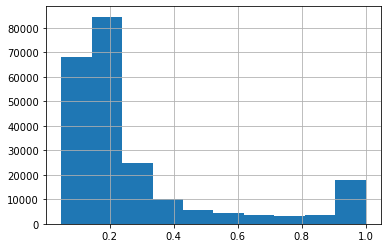

In [70]:
pd.Series(prediction[:, 0]).hist()

In [66]:
submit_df = valid_df.copy()[['id']]

In [67]:
submit_df['target'] = prediction[:, 0]

In [68]:
submit_df.head()

,id,target
0,555fae21f9,0.249721
1,5550b3009c,0.221492
2,55554b8e3c,0.101208
3,55535b070b,0.265458
4,555d90926b,0.992604


In [72]:
submit_df.to_csv(path / 'g2net_submittal.csv', index=False)